<h1> Soft Actor Critic Demystified</h1>
<h4> By Vaishak Kumar </h4>
<br>
<a href="https://arxiv.org/pdf/1801.01290.pdf">Original Paper</a>
<br> 
<a href="https://github.com/higgsfield/RL-Adventure-2">Adapted from higgsfield's implementation</a>

In [10]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cpu")

<h2>Auxilliary Functions</h2>

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [12]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [13]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [14]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

<h1> Update Function </h1>

In [15]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

<h2> Initializations </h2>

In [16]:
env = NormalizedActions(gym.make("Pendulum-v0"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256


print('action dim and state dim', action_dim, state_dim)

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

action dim and state dim 1 3


# Training Hyperparameters

In [17]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

# Training Loop

In [18]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            print('action taken', action.numpy())
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            print('action taken random', action)
            next_state, reward, done, _ = env.step(action)
        
        print('pushing to buffer', state, action, reward, next_state, done)
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            print('len before', len(replay_buffer))
            update(batch_size)
            print('updating')
            print('len after', len(replay_buffer))

        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

action taken random [0.86552936]
pushing to buffer [-0.80717487 -0.5903124   0.23764218] [0.86552936] -6.309481069028912 [-0.8055613  -0.59251245  0.05456666] False
action taken random [-0.21773356]
pushing to buffer [-0.8055613  -0.59251245  0.05456666] [-0.21773356] -6.287634918545229 [-0.81883529 -0.57402854 -0.45513774] False
action taken random [1.1277801]
pushing to buffer [-0.81883529 -0.57402854 -0.45513774] [1.1277801] -6.42650252601907 [-0.83529109 -0.54980796 -0.58565915] False
action taken random [-0.5586401]
pushing to buffer [-0.83529109 -0.54980796 -0.58565915] [-0.5586401] -6.5863749965028076 [-0.86589779 -0.50022097 -1.16560715] False
action taken random [0.4465988]
pushing to buffer [-0.86589779 -0.50022097 -1.16560715] [0.4465988] -6.989217718290373 [-0.89891295 -0.43812727 -1.40679325] False
action taken random [1.5579933]
pushing to buffer [-0.89891295 -0.43812727 -1.40679325] [1.5579933] -7.427672020468315 [-0.92801602 -0.37254029 -1.43538871] False
action taken r

KeyboardInterrupt: 

<h2> Visualize Trained Algorithm </h2> - <a href="http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html">source</a>  

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

/home/vaishak/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


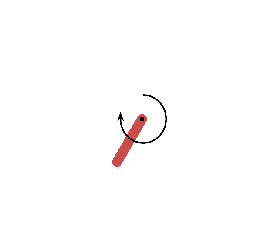

In [ ]:
env = gym.make("Pendulum-v0")

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = policy_net.get_action(state)
    state, reward, done, info = env.step(action.detach())
    if done:
        break
env.close()
display_frames_as_gif(frames)

